In [1]:
from numba import config

# set the threading layer before any parallel target compilation
config.THREADING_LAYER = 'safe'

In [2]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from helpers import subsample_train
from xgboost import XGBClassifier

from automated_scoring.classification import k_fold_predict
from automated_scoring.classification._optimization_utils import evaluate_results
from automated_scoring.classification.visualization import plot_classification_timeline
from automated_scoring.config import cfg
from automated_scoring.features import DataFrameFeatureExtractor
from automated_scoring.io import load_dataset
from automated_scoring.utils import ensure_generator
from automated_scoring.sliding_metrics import sliding_median

from automated_scoring.utils import set_logging_level

In [3]:
cfg.key_keypoints = "keypoints"
cfg.key_timestamp = "timestamps"

cfg.trajectory_keys = (
    "keypoints",
    "timestamps",
)

In [4]:
dataset_train = load_dataset("mice_train", directory="../../datasets/CALMS21/train", target="dyad", background_category="none")
dataset_test = load_dataset("mice_test", directory="../../datasets/CALMS21/test", target="dyad", background_category="none")

2025-02-14 18:30:54.476 | WARNING  | automated_scoring.io:load_dataset:257 - Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.
2025-02-14 18:30:55.134 | WARNING  | automated_scoring.io:load_dataset:257 - Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.


In [5]:
extractor = DataFrameFeatureExtractor(cache_directory="feature_cache_mice").read_yaml("config_file.yaml")

In [6]:
# from automated_scoring.classification.predict import k_fold_predict

# set_logging_level("DEBUG")

# k_fold_result = k_fold_predict(dataset_train, extractor, k=5, classifier=XGBClassifier, exclude_individuals=["intruder"], sampling_func=subsample_train, random_state=1, log=None)

In [7]:
# this cell is equivalent to smoothing_experiment-mice.py
# 5-fold cross-validation is performed num_iteration (20) times to average out stochasticity
# these iterations can be performed in parallel on a cluster (using mpi4py) as they don't depend on each other


from automated_scoring.classification.optimize import optimize_smoothing


def smooth(parameters, array):
    return sliding_median(array, parameters["median_filter_window"])


set_logging_level("SUCCESS")


best_parameters = optimize_smoothing(
    dataset_train,
    extractor,
    XGBClassifier(n_estimators=1000),
    smooth,
    smoothing_parameters_grid={"median_filter_window": np.arange(3, 91, 2)},
    remove_overlapping_predictions=False,
    num_iterations=20,
    k=5,
    exclude_individuals=["intruder"],
    sampling_func=subsample_train,
    tolerance=0.005,
    random_state=1,
    plot_results=False,
    results_path=".",
)

2025-02-14 18:33:00.456 [SUCCESS ] [fold: 0/5] finished predicting on dataset in 8.15 seconds
2025-02-14 18:35:21.936 [SUCCESS ] [fold: 1/5] finished predicting on dataset in 4.57 seconds
2025-02-14 18:37:37.915 [SUCCESS ] [fold: 2/5] finished predicting on dataset in 6.33 seconds
2025-02-14 18:40:00.401 [SUCCESS ] [fold: 3/5] finished predicting on dataset in 5.02 seconds
2025-02-14 18:42:20.772 [SUCCESS ] [fold: 4/5] finished predicting on dataset in 6.27 seconds
2025-02-14 18:42:20.776 [SUCCESS ] finished k-fold cross-validation in 685.45 seconds
2025-02-14 18:43:54.594 [SUCCESS ] finished scoring smoothing parameters in 93.82 seconds
2025-02-14 18:46:08.020 [SUCCESS ] [fold: 0/5] finished predicting on dataset in 6.53 seconds
2025-02-14 18:48:29.372 [SUCCESS ] [fold: 1/5] finished predicting on dataset in 5.85 seconds
2025-02-14 18:50:47.719 [SUCCESS ] [fold: 2/5] finished predicting on dataset in 7.71 seconds
2025-02-14 18:53:05.597 [SUCCESS ] [fold: 3/5] finished predicting on da

In [8]:
best_parameters  # -> {"median_filter_window": 47}

{'median_filter_window': 51.0}

In [9]:
# redifine the smoothing function with the optimal parameter

def optimal_smooth(*, array):
    return sliding_median(array, int(best_parameters["median_filter_window"]))

In [10]:
# this cell is equivalent to smoothing_experiment-mice.py
# (see comment above)

from automated_scoring.classification import optimize_decision_thresholds


set_logging_level("SUCCESS")


best_thresholds = optimize_decision_thresholds(
    dataset_train,
    extractor,
    XGBClassifier(n_estimators=1000),
    remove_overlapping_predictions=False,
    smoothing_func=optimal_smooth,
    num_iterations=20,
    k=5,
    exclude_individuals=["intruder"],
    sampling_func=subsample_train,
    decision_threshold_range=(0.0, 1.0),
    decision_threshold_step=0.01,
    tolerance=0.005,
    random_state=1,
    plot_results=False,
    results_path=".",
)

best_thresholds  # -> {"attack": 0.3, "investigation": 0.0, "mount": 0.0, "none": 0.0}

2025-02-14 22:53:48.883 [SUCCESS ] [fold: 0/5] finished predicting on dataset in 8.15 seconds
2025-02-14 22:56:10.132 [SUCCESS ] [fold: 1/5] finished predicting on dataset in 4.45 seconds
2025-02-14 22:58:26.043 [SUCCESS ] [fold: 2/5] finished predicting on dataset in 6.47 seconds
2025-02-14 23:00:46.415 [SUCCESS ] [fold: 3/5] finished predicting on dataset in 5.06 seconds
2025-02-14 23:03:05.688 [SUCCESS ] [fold: 4/5] finished predicting on dataset in 6.35 seconds
2025-02-14 23:03:05.691 [SUCCESS ] finished k-fold cross-validation in 686.55 seconds
2025-02-14 23:10:48.010 [SUCCESS ] finished scoring decision thresholds in 461.21 seconds
2025-02-14 23:12:59.372 [SUCCESS ] [fold: 0/5] finished predicting on dataset in 6.47 seconds
2025-02-14 23:15:20.097 [SUCCESS ] [fold: 1/5] finished predicting on dataset in 6.00 seconds
2025-02-14 23:17:38.005 [SUCCESS ] [fold: 2/5] finished predicting on dataset in 7.71 seconds
2025-02-14 23:19:54.969 [SUCCESS ] [fold: 3/5] finished predicting on da

({'threshold_attack': 0.4},
 {'threshold_investigation': 0.0},
 {'threshold_mount': 0.0},
 {'threshold_none': 0.0})

In [11]:
best_thresholds

({'threshold_attack': 0.4},
 {'threshold_investigation': 0.0},
 {'threshold_mount': 0.0},
 {'threshold_none': 0.0})

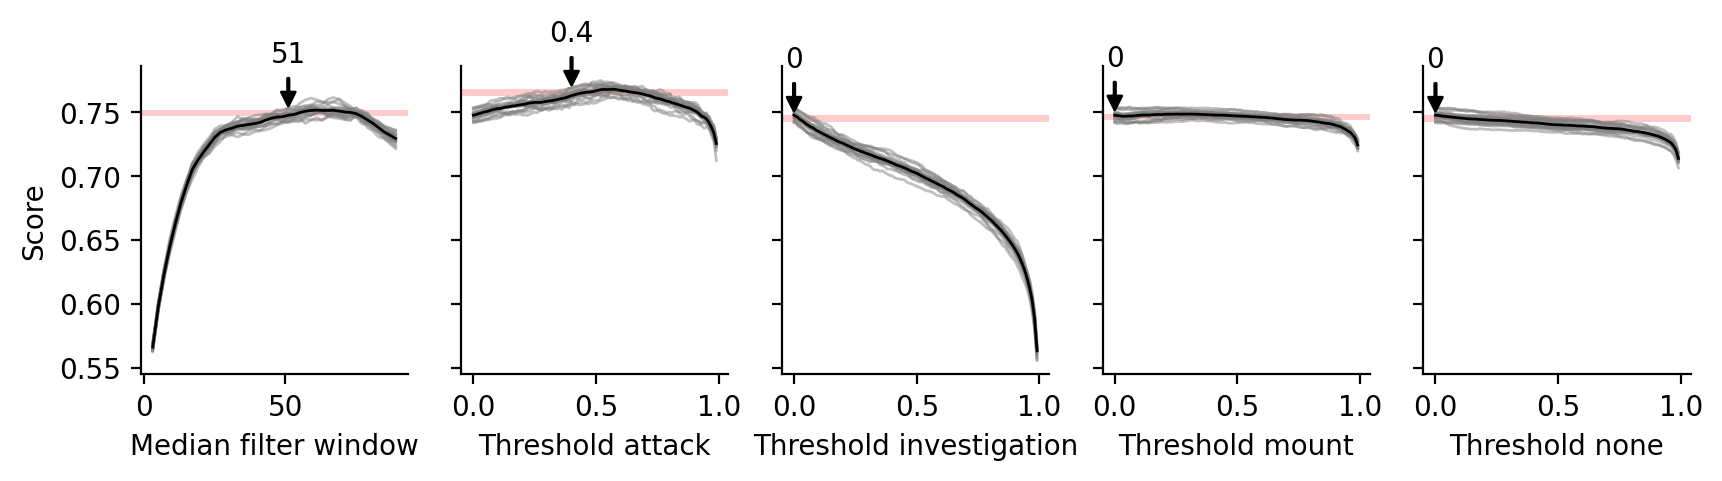

In [12]:
# instead, load results from smoothing_experiment-mice.py and thresholding_experiment-mice.py cluster runs

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(dataset_train.categories) + 1, sharey=True, figsize=(10, 2))

smoothing_results = pd.read_csv("results_smoothing.csv", index_col=0)
evaluate_results(smoothing_results, parameter_names=["median_filter_window"], tolerance=0.005, plot_results=True, axes=axes[[0]])

for category_idx, category in enumerate(dataset_train.categories):
    thresholding_results_category = pd.read_csv(f"results_thresholding-{category}.csv", index_col=0)
    evaluate_results(
        thresholding_results_category,
        parameter_names=[f"threshold_{category}"],
        tolerance=0.005,
        plot_results=True,
        axes=axes[[category_idx + 1]]
    )

for ax in axes[1:]:
    ax.set_ylabel("")

In [15]:
set_logging_level("SUCCESS")

k_fold_result = k_fold_predict(
    dataset_train,
    extractor,
    XGBClassifier(n_estimators=1000, random_state=1),
    k=5,
    exclude_individuals=["intruder"],
    random_state=ensure_generator(1),
    sampling_func=subsample_train,
).smooth([optimal_smooth], decision_thresholds=[0.4, 0, 0, 0])

2025-02-17 11:08:30.612 [SUCCESS ] [fold: 0/5] finished predicting on dataset in 7.77 seconds
2025-02-17 11:11:09.299 [SUCCESS ] [fold: 1/5] finished predicting on dataset in 5.23 seconds
2025-02-17 11:13:49.746 [SUCCESS ] [fold: 2/5] finished predicting on dataset in 7.32 seconds
2025-02-17 11:16:31.753 [SUCCESS ] [fold: 3/5] finished predicting on dataset in 5.81 seconds
2025-02-17 11:19:08.120 [SUCCESS ] [fold: 4/5] finished predicting on dataset in 5.84 seconds
2025-02-17 11:19:08.123 [SUCCESS ] finished k-fold cross-validation in 779.54 seconds


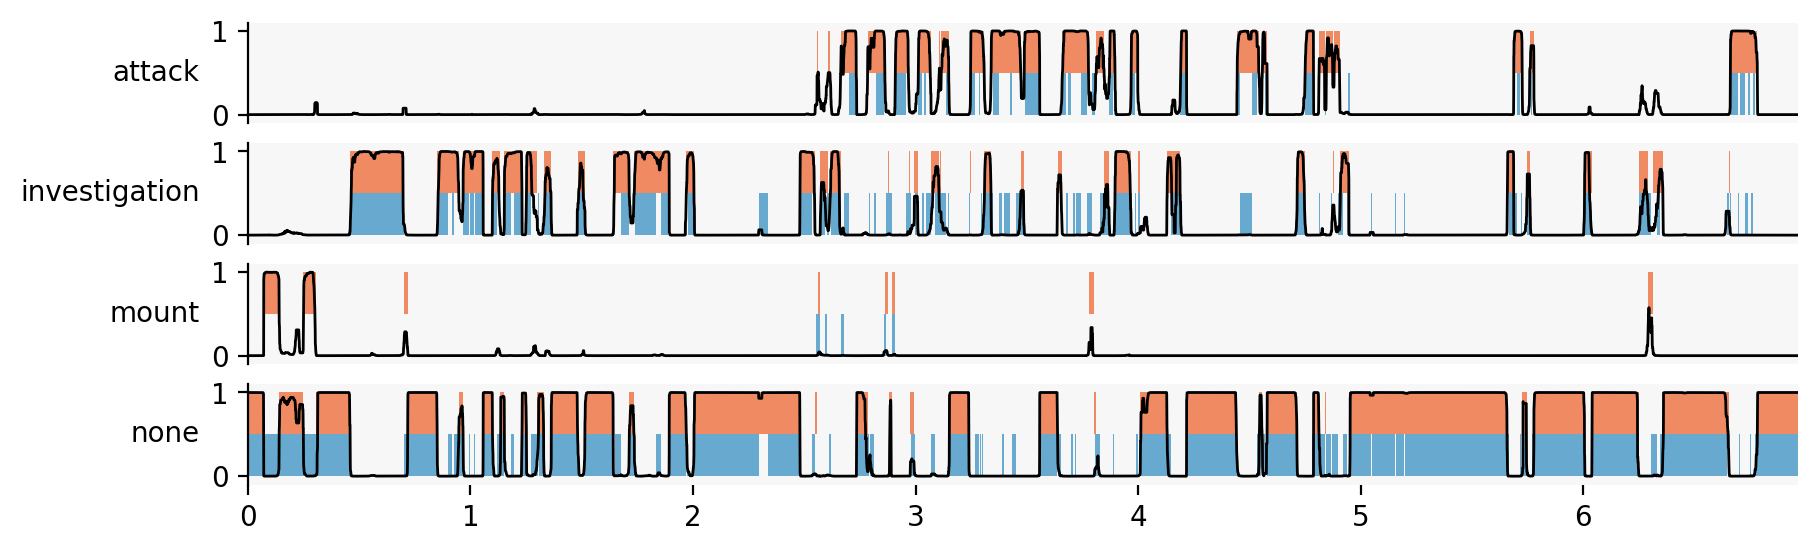

In [22]:
dyad_results = k_fold_result.classification_results[69].classification_results[('resident', 'intruder')]

plot_classification_timeline(
    dyad_results.predictions,
    dyad_results.categories,
    annotations=dyad_results.annotations,
    timestamps=dyad_results.timestamps,
    interval=(-np.inf, np.inf),
    # y_proba=dyad_results.y_proba,
    y_proba_smoothed=dyad_results.y_proba_smoothed,
    x_tick_step=(60 * 30),
    x_tick_conversion=lambda ticks: [int(tick / (30 * 60)) for tick in ticks],
)